Select a dataset with a continuous target variable.

Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from math import sqrt

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


import os
import env
import wrangle

In [2]:
train, validate, test = wrangle.wrangle_zillow()
train_scaled, validate_scaled, test_scaled = wrangle.scale_data(train, validate, test)

In [4]:
train_scaled.head(2)

,bedrooms,bathrooms,square_feet,tax_value,year_built,lot_square_feet,fips,region_zip,logerror,transaction_date,decade
21694,0.250,0.153846,0.172007,555396.0,1964.0,0.592626,6111.0,97099.0,0.027871,2017-05-09,1960s
25472,0.375,0.307692,0.532040,239759.0,1976.0,0.892787,6037.0,96346.0,-0.002743,2017-05-11,1970s


In [6]:
cols = ['bedrooms', 'bathrooms', 'square_feet', 'year_built']
X_train = train_scaled[cols]
y_train = train_scaled['tax_value']
X_validate = validate_scaled[cols]
y_validate = validate_scaled['tax_value']
X_test = test_scaled[cols]
y_test = test_scaled['tax_value']

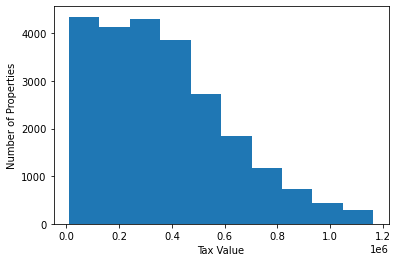

In [7]:
plt.hist(y_train)
plt.xlabel("Tax Value")
plt.ylabel("Number of Properties")
plt.show()

In [9]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  247005.06 
Validate/Out-of-Sample:  247235.59
RMSE using Median
Train/In-Sample:  249922.49 
Validate/Out-of-Sample:  250405.9


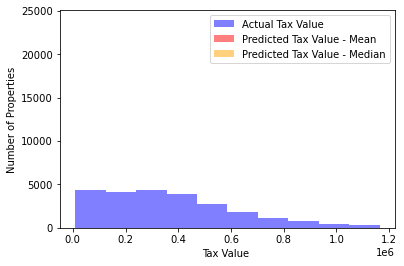

In [98]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.tax_value_pred_mean, bins=1, color='red', alpha=.5, 
         label="Predicted Tax Value - Mean")
plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5,
         label="Predicted Tax Value - Median")
plt.xlabel("Tax Value ")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()


In [66]:
y_train

,tax_value,tax_value_pred_mean,tax_value_pred_median,tax_value_pred_lm,tax_value_pred_lars,tax_value_pred_glm,tax_value_pred_lm2
21694,555396.0,370806.595592,332731.0,231343.085780,231564.244369,370806.595592,222183.922022
25472,239759.0,370806.595592,332731.0,463264.804909,463219.319787,370806.595592,454577.513553
49290,159968.0,370806.595592,332731.0,291240.869771,290959.254869,370806.595592,282861.166871
16497,484019.0,370806.595592,332731.0,306065.926939,306585.420401,370806.595592,304067.779863
12153,452000.0,370806.595592,332731.0,235164.118018,235612.963273,370806.595592,254359.783960
...,...,...,...,...,...,...,...
22052,443691.0,370806.595592,332731.0,515098.074539,514991.067875,370806.595592,498493.764318
19819,51116.0,370806.595592,332731.0,337834.968952,337869.754591,370806.595592,330404.096249
42851,821920.0,370806.595592,332731.0,309040.429475,308688.839279,370806.595592,293990.784146
10004,686110.0,370806.595592,332731.0,672331.334266,671420.281652,370806.595592,661729.546521


### LinearRegression (OLS)
- Fit the model using X_train_scaled and the labels from y_train.

- Predict final grade for students in training sample using our model (lm).

- Evaluate using RMSE

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

In [22]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  216070.91027729897 
Validation/Out-of-Sample:  219441.11626412667


### LassoLars
- Fit the model using X_train_scaled and the labels from y_train.

- Predict final grade for students in training sample using our model (lars).

- Evaluate using RMSE

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

In [23]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  216071.26349673182 
Validation/Out-of-Sample:  219434.38830530853


### TweedieRegressor (GLM)
- Fit the model using X_train_scaled and the labels from y_train.

- Predict final grade for students in training sample using our model (glm).

- Evaluate using RMSE

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

In [24]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  247005.0565394129 
Validation/Out-of-Sample:  247235.59337214922


### Polynomial Regression
#### Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

- Create the new features, based on value indicated for degree for train, validate & test.

- Fit the Linear Regression model

- Predict using the transformed (squared or cubed, e.g.) features

- Evaluate using RMSE

- Repeat predictions and evaluation for validation.

- Compare RMSE train vs. validation. Overfitting?

In [25]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [26]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  215111.80672004007 
Validation/Out-of-Sample:  218814.9759612123


### Evaluate

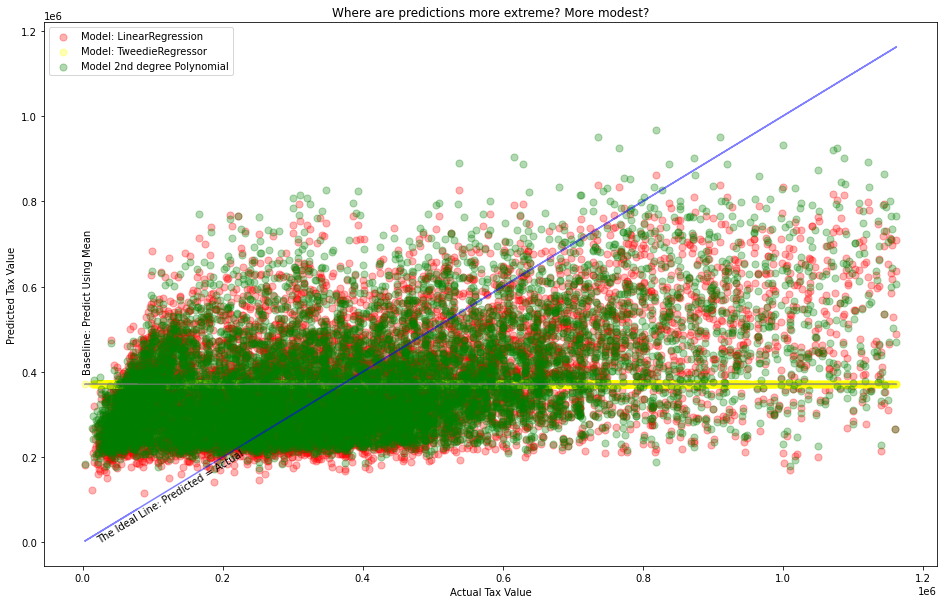

In [52]:
# y_validate.head()
plt.figure(figsize=(16,10))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.7, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 400000.5), rotation=90)
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (19000, 1.5), rotation=31.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.3, color="red", s=50, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.3, color="yellow", s=50, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.3, color="green", s=50, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

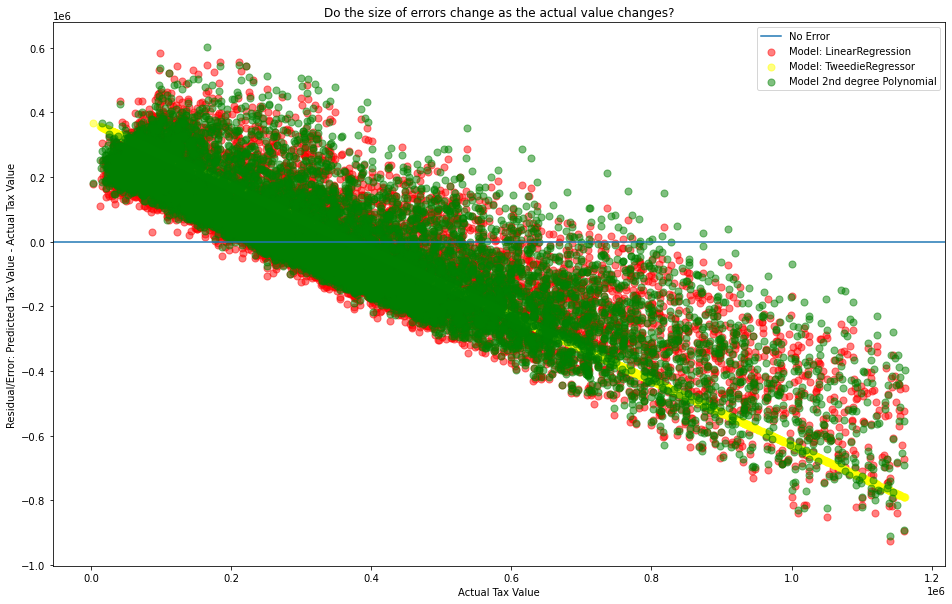

In [53]:
# y_validate.head()
plt.figure(figsize=(16,10))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=.5, color="red", s=50, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=.5, color="yellow", s=50, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="green", s=50, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()


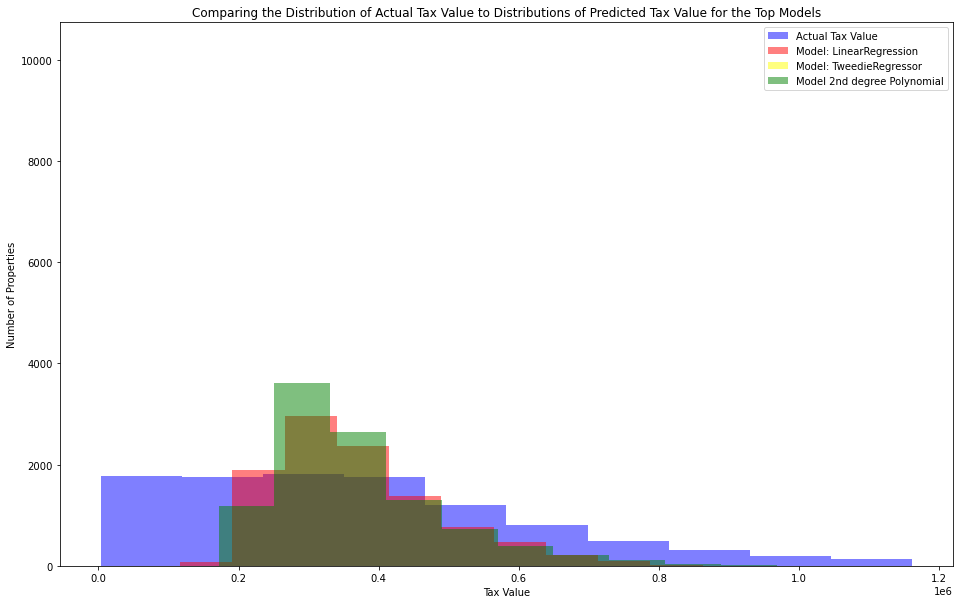

In [51]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Value for the Top Models")
plt.legend()
plt.show()

In [55]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  217598.93482546243
